# STAT 531 Final Project

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from math import radians, sin, cos, atan2, sqrt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
sns.set_style('whitegrid'); warnings.filterwarnings('ignore')

# ---------- Load & preprocess ----------
df = pd.read_csv('tripinfo_details.csv')

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2-lat1); dl = np.radians(lon2-lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dl/2)**2
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

req = ['Origin Latitude','Origin Longitude','Destination Latitude','Destination Longitude',
       'Route Length','Duration','Waiting Time','Stop Time','Time Loss']
df = df.dropna(subset=req)
df['EuclDist'] = haversine(df['Origin Latitude'],df['Origin Longitude'],
                           df['Destination Latitude'],df['Destination Longitude'])
df = df[df['EuclDist']>0]
df['Circuity'] = df['Route Length']/df['EuclDist']
df = df[(df['Circuity']>1)&(df['Circuity']<5)]
df['AvgSpeed'] = df['Route Length']/df['Duration']
if 'Type' in df.columns:
    df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# ---------- Features ----------
feature_cols = ['Duration','Waiting Time','Stop Time','Time Loss',
                'Route Length','EuclDist','AvgSpeed'] + [c for c in df.columns if c.startswith('Type_')]
X = df[feature_cols]; y = df['Circuity']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
scaler = StandardScaler(); X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)

# ---------- Models ----------
models = {
    'Random Forest': RandomForestRegressor(n_estimators=300,random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=300,random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=300,random_state=42),
    'SVM': SVR(kernel='rbf'),
    'Stacking': StackingRegressor(
        estimators=[('rf', RandomForestRegressor(n_estimators=150,random_state=42)),
                    ('gb', GradientBoostingRegressor(random_state=42))],
        final_estimator=LinearRegression()
    )
}
res=[]
for n,m in models.items():
    m.fit(X_train_s,y_train); pred=m.predict(X_test_s)
    res.append({'Model':n,'MAE':mean_absolute_error(y_test,pred),
                'RMSE':mean_squared_error(y_test,pred,squared=False),
                'R2':r2_score(y_test,pred)})
results_df = pd.DataFrame(res).sort_values('RMSE')
best_name = results_df.iloc[0]['Model']; best_model = models[best_name]
print(results_df)


               Model       MAE      RMSE        R2
0      Random Forest  0.010437  0.036978  0.969010
4           Stacking  0.012819  0.037110  0.968788
1  Gradient Boosting  0.023816  0.043430  0.957251
3                SVM  0.059446  0.101670  0.765727
2           AdaBoost  0.201453  0.231584 -0.215511


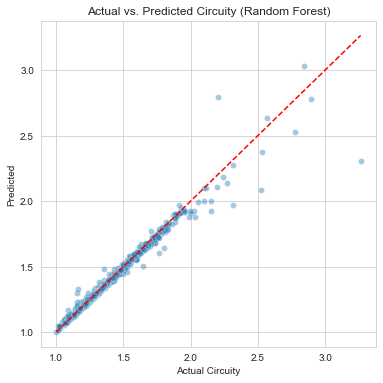

In [2]:

pred_best = best_model.predict(X_test_s)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_best, alpha=0.4)
lims=[y_test.min(), y_test.max()]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Circuity'); plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Circuity ({best_name})')
plt.show()


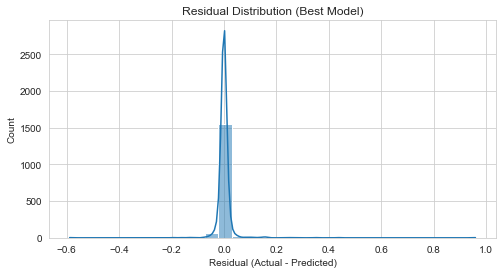

In [3]:

resid = y_test - pred_best
plt.figure(figsize=(8,4))
sns.histplot(resid, bins=30, kde=True)
plt.title('Residual Distribution (Best Model)')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


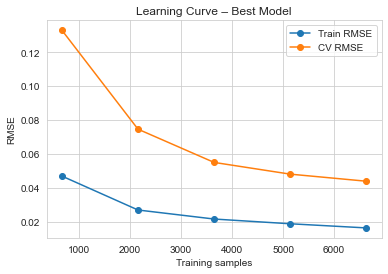

In [4]:

train_sizes, train_scores, test_scores = learning_curve(best_model, scaler.transform(X), y,
                                                        train_sizes=np.linspace(0.1,1.0,5),
                                                        scoring='neg_root_mean_squared_error',
                                                        cv=5, n_jobs=-1)
train_rmse = -train_scores.mean(axis=1)
test_rmse = -test_scores.mean(axis=1)
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='CV RMSE')
plt.xlabel('Training samples'); plt.ylabel('RMSE')
plt.title('Learning Curve – Best Model')
plt.legend(); plt.show()


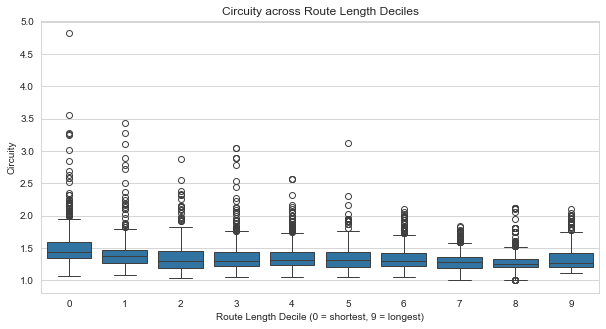

In [5]:

df['RouteBin'] = pd.qcut(df['Route Length'], q=10, labels=False)
plt.figure(figsize=(10,5))
sns.boxplot(x='RouteBin', y='Circuity', data=df)
plt.title('Circuity across Route Length Deciles')
plt.xlabel('Route Length Decile (0 = shortest, 9 = longest)')
plt.show()


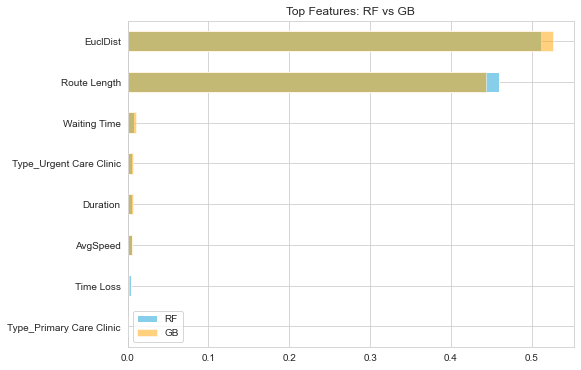

In [6]:

rf_imp = pd.Series(models['Random Forest'].feature_importances_, index=feature_cols)
gb_imp = pd.Series(models['Gradient Boosting'].feature_importances_, index=feature_cols)
plt.figure(figsize=(8,6))
rf_imp.sort_values().tail(8).plot(kind='barh', label='RF', color='skyblue')
gb_imp.sort_values().tail(8).plot(kind='barh', alpha=0.5, label='GB', color='orange')
plt.legend(); plt.title('Top Features: RF vs GB'); plt.show()
